In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from plotly import graph_objects as go
from tqdm.notebook import tqdm

from src import algorithms, optimizers, types, utils

In [3]:
n = 1_000
d = 50

x, y = algorithms.generate_points(n, d)

## 1. Реализуйте стохастический градиентный спуск для решения линейной регрессии. Исследуйте сходимость с разным размером батча (1 - SGD, 2, .., n − 1 - Minibatch GD, n - GD из предыдущей работы)

### 1.1 Проверим, что градиентный спуск работает

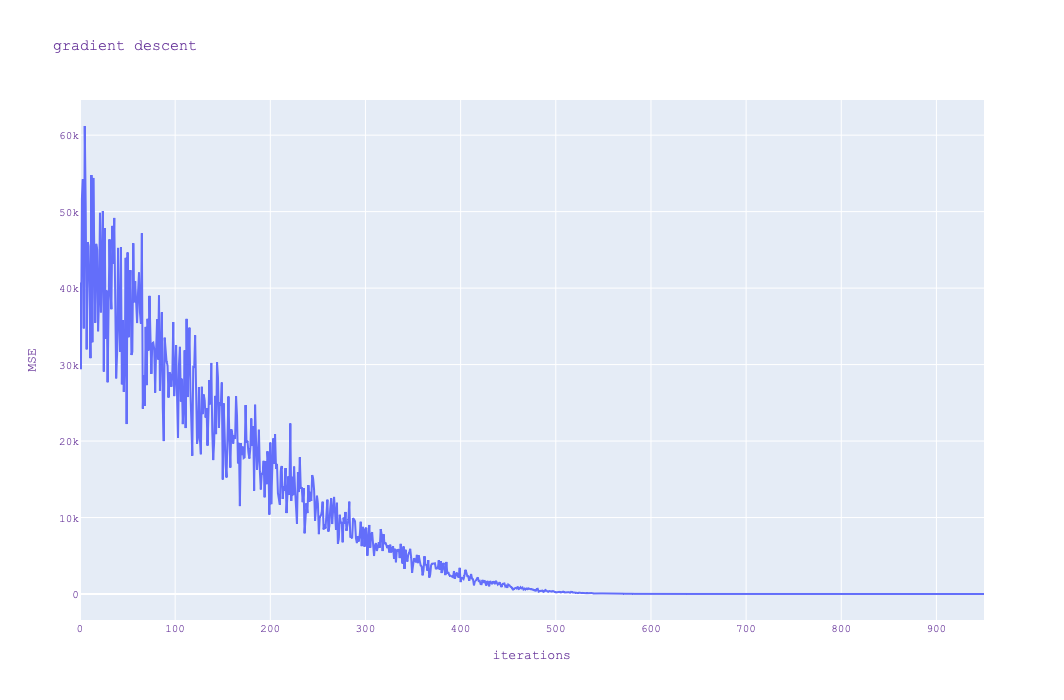

In [12]:
optimizer = optimizers.Standard(lr=0.01)
loss_history = algorithms.run_gradient_descent(
    x, 
    y, 
    batch_size=50, 
    optimizer=optimizer,
    num_iters=1_000, 
    eps=1e-3,
)

fig = go.Figure()
fig.add_trace(go.Scatter(y=loss_history))
utils.update_layout(fig, 'gradient descent', "iterations", "MSE")
fig.show()

### 1.2 Теперь посмотрим как разные размера батча влияют на сходимость

  0%|          | 0/10 [00:00<?, ?it/s]

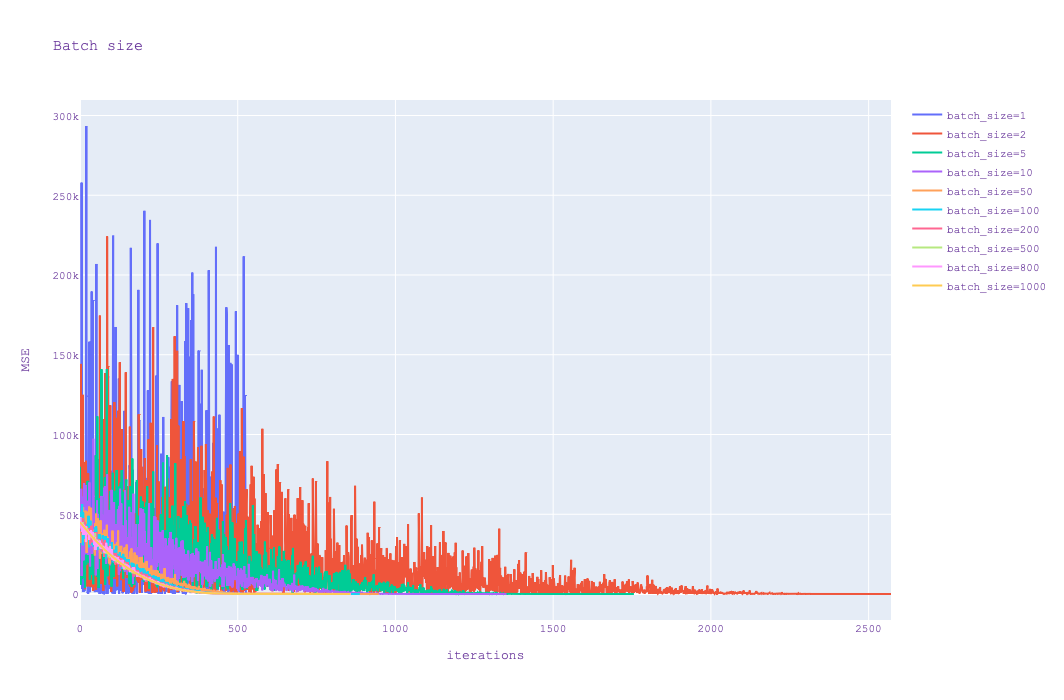

,batch,iterations
0,1,1970 ± 850
1,2,2534 ± 55
2,5,1726 ± 28
3,10,1359 ± 7
4,50,952 ± 6
5,100,886 ± 2
6,200,862 ± 2
7,500,858 ± 1
8,800,860 ± 2
9,1000,858 ± 0


In [113]:
fig = go.Figure()
df = []
for batch_size in tqdm([1, 2, 5, 10, 50, 100, 200, 500, 800, 1_000]):
    optimizer = optimizers.Standard(lr=0.01)
    iter_mean, iter_std, loss_history = algorithms.multiple_run(
        x, 
        y, 
        batch_size=batch_size, 
        optimizer=optimizer,
        num_iters=10_000, 
        eps=1e-3,
        return_history=True,
    )
    df.append({'batch': batch_size, 'iterations': f'{iter_mean:.0f} ± {iter_std:.0f}'})
    fig.add_trace(go.Scatter(y=loss_history, name=f'{batch_size=}'))

utils.update_layout(fig, f'Batch size', "iterations", "MSE")
fig.show()
pd.DataFrame(df)

Видно, что с увеличением размера батча значения лосс-функции уменьшается более равномерно

При маленьком размере батча функция сходится за большее количество итераций.

Также видно, что количество итераций для размера батча от 100 до 1000 практически не отличается

## 2. Подберите функцию изменения шага (learning rate scheduling), чтобы улучшить сходимость, например экспоненциальную или ступенчатую.

В предыдущих экспериментах использовалось достаточно маленькое значение lr = 0.01, поэтому для него нет необходимости добавлять scheduling. Чтобы проверить exponential scheduling увеличим lr до 0.7.

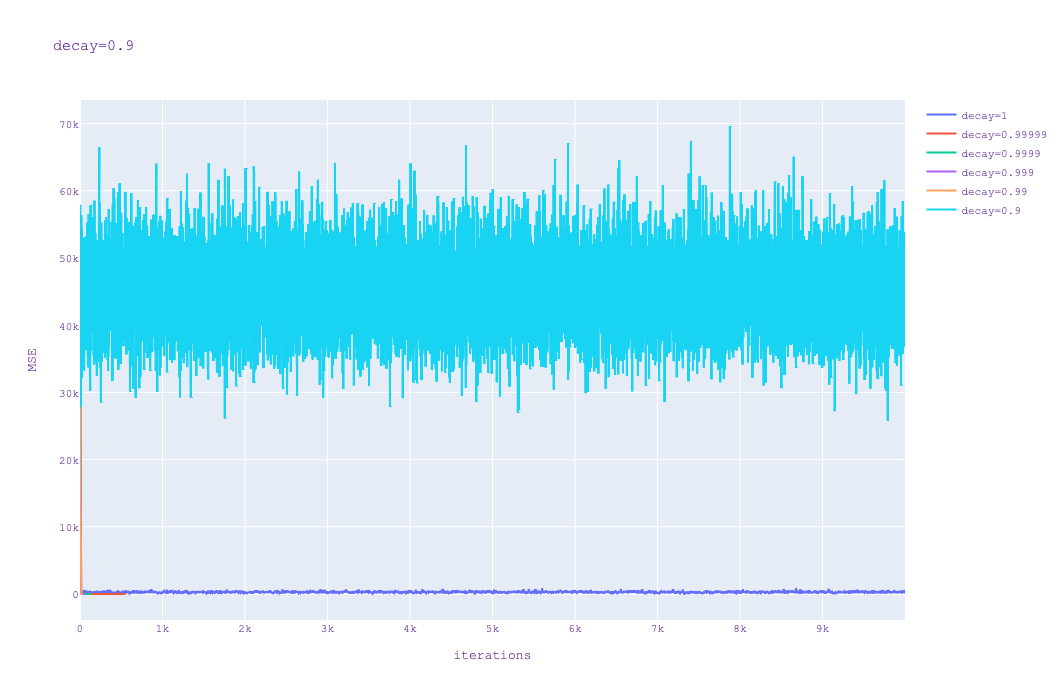

,decay,iterations
0,1.00000,10000 ± 0
1,0.99999,6420 ± 4413
2,0.99990,930 ± 1904
3,0.99900,164 ± 246
4,0.99000,46 ± 37
5,0.90000,4026 ± 4877


In [112]:
df = []
fig = go.Figure()
for decay in [1, 0.99999, 0.9999, 0.999, 0.99, 0.9]:
    optimizer = optimizers.Standard(lr=0.7, decay=decay)
    iter_mean, iter_std, loss_history = algorithms.multiple_run(
        x, 
        y, 
        batch_size=100, 
        optimizer=optimizer,
        num_iters=10_000, 
        eps=1e-3,
        return_history=True,
    )
    df.append({'decay': decay, 'iterations': f'{iter_mean:.0f} ± {iter_std:.0f}'})
    fig.add_trace(go.Scatter(y=loss_history, name=f'{decay=}'))

utils.update_layout(fig, f'{decay=}', "iterations", "MSE")
fig.show()    
pd.DataFrame(df)

Если $decay \geqslant 0.9999$, то learning rate не успевает уменьшиться и алгоритм не может сойтись к правильной точности

Если $decay \in \{0.999, 0.99\}$, то алгоритм сходится

Если $decay \leqslant 0.9$, то learning rate слишком быстро уменьшается и алгоритм не сходится

## 3. Исследуйте сходимость алгоритмов. Сравнить различные методы по скорости сходимости, надежности, требуемым машинным ресурсам

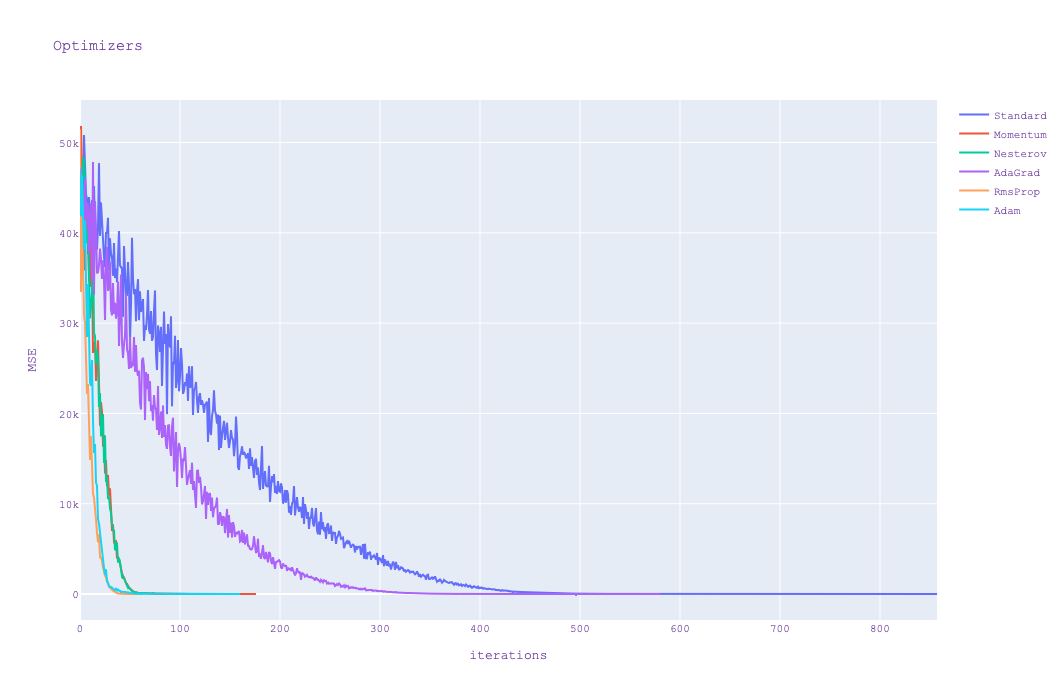

,optimizer,iterations,time
0,Standard,861 ± 2,0.115ms
1,Momentum,177 ± 1,0.217ms
2,Nesterov,160 ± 1,0.110ms
3,AdaGrad,300 ± 168,0.108ms
4,RmsProp,58 ± 9,0.101ms
5,Adam,162 ± 2,0.120ms


In [130]:
df = []
fig = go.Figure()

for name, params in [
    ('Standard', dict(lr=0.01)),
    ('Momentum', dict(lr=0.01, momentum=0.9)),
    ('Nesterov', dict(lr=0.01, momentum=0.9)),
    ('AdaGrad', dict(lr=10)),
    ('RmsProp', dict(lr=1)),
    ('Adam', dict(lr=1, betta1=0.9, betta2=0.999)),
]:
    optim = getattr(optimizers, name)(**params)
    iter_mean, iter_std, loss_history = algorithms.multiple_run(
        x, 
        y, 
        batch_size=200, 
        optimizer=optim,
        num_iters=1_000, 
        eps=1e-3,
        return_history=True,
    )
    
    mean_time = optim.time_sum / optim.time_cnt / 10 ** 6
    
    df.append({'optimizer': name, 'iterations': f'{iter_mean:.0f} ± {iter_std:.0f}', 'time': f'{mean_time:.3f}ms'})
    fig.add_trace(go.Scatter(y=loss_history, name=name))
    
utils.update_layout(fig, f'Optimizers', "iterations", "MSE")
fig.show()
pd.DataFrame(df)

В среднем быстрее всех сходится алгоритм RmsProp за 58 итераций. В следующем блоке 160-180 итераций находятся Adam, Nesterov и Momentum. Причем Adam достигает значения MSE 500 с такой же скоростью как RmsProp, а затем сходится медленнее

Затем алгоритм AdaGrad сходится в среднем за 300 итераций. Но большое значение std – 168 говорит о том, что количество итераций может отличаться в несколько раз в зависимости от начальной точки

Больше всех итераций требует стандартный алгоритм с константным learning rate

### Время работы 
Все алгоритмы кроме стандартного пересчитывают изменение параметров за $\mathcal{O}(d)$. Также один шаг оптимизации во всех алгоритмах занимает примерно 100ms. Поэтому суммарно быстрее работает алгоритм с меньшим количеством итераций

## 5. Траектории для 1-D регрессии

In [138]:
n = 1_000
d = 1

x, y = algorithms.generate_points(n, d)

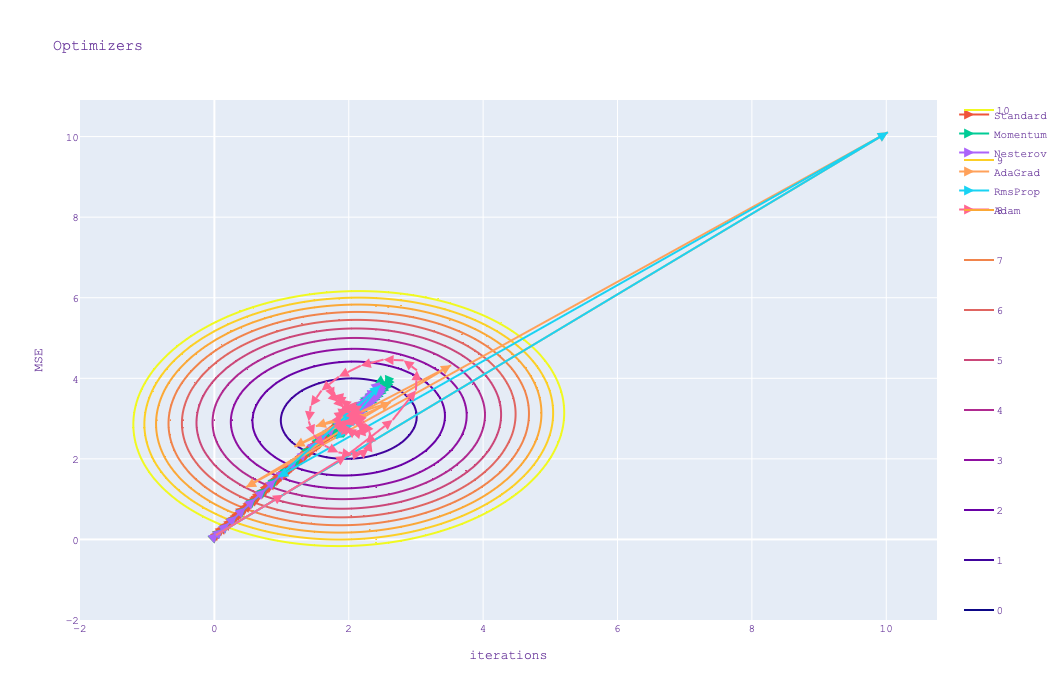

,optimizer,iterations,time
0,Standard,248 ± 0,0.026ms
1,Momentum,62 ± 0,0.026ms
2,Nesterov,41 ± 0,0.028ms
3,AdaGrad,13 ± 0,0.029ms
4,RmsProp,13 ± 0,0.030ms
5,Adam,57 ± 0,0.034ms


In [153]:
df = []
fig = go.Figure(types.LinearRegression.get_contour(x, y, -2, 7, 50))

for name, params in [
    ('Standard', dict(lr=0.01)),
    ('Momentum', dict(lr=0.01, momentum=0.9)),
    ('Nesterov', dict(lr=0.01, momentum=0.9)),
    ('AdaGrad', dict(lr=10)),
    ('RmsProp', dict(lr=1)),
    ('Adam', dict(lr=1, betta1=0.9, betta2=0.999)),
]:
    optim = getattr(optimizers, name)(**params)
    iter_mean, iter_std, loss_history = algorithms.multiple_run(
        x, 
        y, 
        batch_size=200, 
        optimizer=optim,
        num_iters=1_000, 
        eps=1e-3,
        return_history=True,
        multiple_cnt=1,
    )
    
    mean_time = optim.time_sum / optim.time_cnt / 10 ** 6
    
    df.append({'optimizer': name, 'iterations': f'{iter_mean:.0f} ± {iter_std:.0f}', 'time': f'{mean_time:.3f}ms'})
    fig.add_trace(go.Scatter(
        optim.get_history(),
        mode='markers+lines',
        marker=dict(size=10, symbol="arrow-bar-up", angleref="previous"),
        name=name,
    ))
    
utils.update_layout(fig, f'Optimizers', "iterations", "MSE")
fig.show()
pd.DataFrame(df)